In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

In [2]:
lit_period = 51.4213
lit_t0 = 2458901.6949978997
t0 = lit_t0

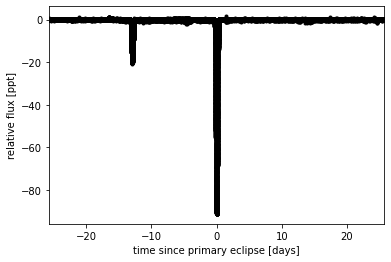

In [3]:
x, y, yerr = np.loadtxt('data/photometry/tess_corrected.txt',usecols=(0,1,2)).T
x += 2457000

# m = (x < t0+1) & (x > t0-1)
# t1 = x[~m][np.argmin(y[~m])]

# m |= (x < t1+1) & (x > t1-1)

# # x = x[m]
# # y = y[m]

x = np.ascontiguousarray(x, dtype=np.float64)
y = np.ascontiguousarray(y, dtype=np.float64)
mu = np.median(y)
y = (y / mu - 1) * 1e3

plt.plot((x - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period, y, ".k")
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.xlabel("time since primary eclipse [days]")
_ = plt.ylabel("relative flux [ppt]")

In [4]:
# fold_hip =  hip_t % lit_period / lit_period
# fold_tess = x % lit_period / lit_period
# fold_asasn = asasn_t % lit_period / lit_period
# plt.plot(fold_tess, y /1e3 + 1, ',k')
# plt.plot(fold_hip, hip_y, '.')
# # plt.plot(fold_asasn, asasn_y, '.')

# # plt.xlim(0.6, 0.8)
# # plt.ylim(0.8, 1.2)

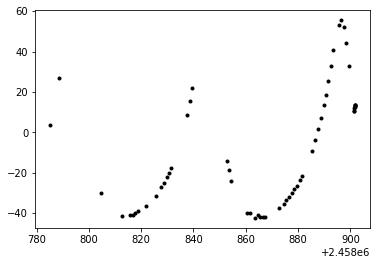

In [5]:
ref_rv = 2400000

x_rv_primary, y_rv_primary = np.loadtxt('data/RV/SONG.txt', usecols=(0,1)).T
x_rv_primary += ref_rv
# x_rv_secondary, y_rv_secondary = np.loadtxt('data/RV/SONG_secondary.txt', usecols=(0,1)).T

plt.plot(x_rv_primary, y_rv_primary, '.k')
# plt.plot(x_rv_secondary, y_rv_secondary, '.k')

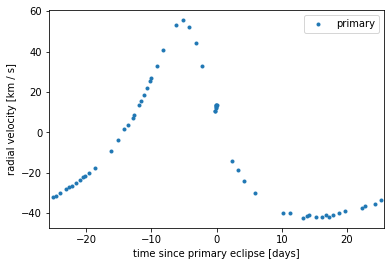

In [6]:
x_rv = np.ascontiguousarray(x_rv_primary, dtype=np.float64)
y1_rv = np.ascontiguousarray(y_rv_primary, dtype=np.float64)
# y1_rv -= np.median(y1_rv)
# y2_rv = np.ascontiguousarray(y_rv_secondary, dtype=np.float64)
# y2_rv -= np.median(y2_rv)


fold = (x_rv - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period

# # m = (fold < 1) & (fold > -1)
# x_rv = x_rv[~m]
# y1_rv = y1_rv[~m]
# y2_rv = y2_rv[~m]
fold = (x_rv - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period


plt.plot(fold, y1_rv, ".", label="primary")
# plt.plot(fold, y2_rv, ".", label="secondary")
plt.legend(fontsize=10)
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.ylabel("radial velocity [km / s]")
_ = plt.xlabel("time since primary eclipse [days]")

Text(0.5, 0, 'Orbital phase')

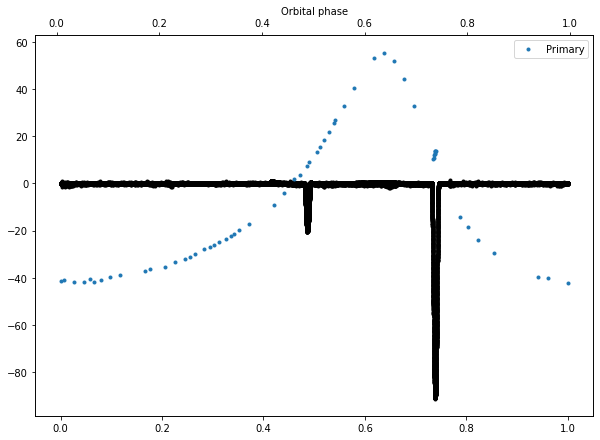

In [7]:
plt.figure(figsize=[10,7])

plt.plot(x % lit_period / lit_period, y, '.k')
ax2 = plt.twiny()
ax2.plot(x_rv % lit_period / lit_period, y1_rv, '.', label='Primary')
# ax2.plot(x_rv % lit_period / lit_period, y2_rv, '.', label='Secondary')
plt.legend()

plt.xlabel('Orbital phase')
# plt.savefig('joint.png', dpi=300, bbox_inches='tight')

In [8]:
lit_flux_ratio = ((0.674)**3.5, 0.2)

In [9]:
e = 0.41346
w = 0.2786
e*np.cos(w), e*np.sin(w)

(0.3975175588699947, 0.11370559348616191)

In [10]:
import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo
import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess


def build_model(mask):

    with pm.Model() as model:

        # Systemic parameters
        mean_lc = pm.Normal("mean_lc", mu=0.0, sd=5.0)
        mean_rv = pm.Normal("mean_rv", mu=0.0, sd=50.0, testval=-11.958)
        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary
        M1 = pm.Lognormal("M1", mu=0.0, sigma=10.0)
        R1 = pm.Lognormal("R1", mu=0.0, sigma=10.0)

        # Secondary ratios
        k = pm.Lognormal("k", mu=0.0, sigma=10.0, testval=0.489)  # radius ratio
        q = pm.Lognormal("q", mu=0.0, sigma=10.0, testval=0.431)  # mass ratio
        s = pm.Lognormal(
            "s", mu=np.log(0.5), sigma=10.0, testval=0.96
        )  # surface brightness ratio

        # Prior on flux ratio
        pm.Normal(
            "flux_prior",
            mu=lit_flux_ratio[0],
            sigma=lit_flux_ratio[1],
            observed=k ** 2 * s,
        )

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=k, testval=0.96)
        period = pm.Lognormal("period", mu=np.log(lit_period), sigma=1.0)
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0)

        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.39560787, 0.14746746]))
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs ** 2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", k * R1)
        M2 = pm.Deterministic("M2", q * M1)
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)

        # Noise model for the light curve
        sigma_lc = pm.InverseGamma(
            "sigma_lc",
            testval=1.0,
            **xo.estimate_inverse_gamma_parameters(0.1, 2.0)
        )
        sigma_gp = pm.InverseGamma(
            "sigma_gp",
            testval=0.5,
            **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        rho_gp = pm.InverseGamma(
            "rho_gp",
            testval=5.0,
            **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        kernel_lc = terms.SHOTerm(sigma=sigma_gp, rho=rho_gp, Q=1.0 / 3)

        # Noise model for the radial velocities
        sigma_rv1 = pm.InverseGamma(
            "sigma_rv1",
            testval=1.0,
            **xo.estimate_inverse_gamma_parameters(0.5, 5.0)
        )
        sigma_rv_gp = pm.InverseGamma(
            "sigma_rv_gp",
            testval=1.5,
            **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        rho_rv_gp = pm.InverseGamma(
            "rho_rv_gp",
            testval=2.0,
            **xo.estimate_inverse_gamma_parameters(1.0, 25.0)
        )
        kernel_rv = terms.SHOTerm(sigma=sigma_rv_gp, w0=rho_rv_gp, Q=1.0 / 3)

        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, s)

        def model_lc(t):
            return (
                mean_lc
                + 1e3
                * lc.get_light_curve(orbit=orbit, r=R2, t=t, 
#                                      texp=texp
                                    )[:, 0]
            )

        # Condition the light curve model on the data
        gp_lc = GaussianProcess(
            kernel_lc, t=x[mask], yerr=sigma_lc, mean=model_lc
        )
        gp_lc.marginal("obs_lc", observed=y[mask])

        # Set up the radial velocity model
        def model_rv1(t):
            return mean_rv + 1e-3 * orbit.get_radial_velocity(t)

        # Condition the radial velocity model on the data
        gp_rv1 = GaussianProcess(
            kernel_rv, t=x_rv, yerr=sigma_rv1, mean=model_rv1
        )
        gp_rv1.marginal("obs_rv1", observed=y1_rv)

        # Optimize the logp
        map_soln = model.test_point

        # First the RV parameters
        map_soln = pmx.optimize(map_soln, [mean_rv, q])
        map_soln = pmx.optimize(
            map_soln, [mean_rv, sigma_rv1, sigma_rv_gp, rho_rv_gp]
        )

        # Then the LC parameters
        map_soln = pmx.optimize(map_soln, [mean_lc, R1, k, s, b])
        map_soln = pmx.optimize(map_soln, [mean_lc, R1, k, s, b, u1, u2])
        map_soln = pmx.optimize(
            map_soln, [mean_lc, sigma_lc, sigma_gp, rho_gp]
        )
        map_soln = pmx.optimize(map_soln, [t0, period])

        # Then all the parameters together
        map_soln = pmx.optimize(map_soln, [mean_rv, q, ecs])
        map_soln = pmx.optimize(map_soln)

        model.gp_lc = gp_lc
        model.gp_lc_pred = gp_lc.predict(y[mask], include_mean=False)
        model.model_lc = model_lc
        model.gp_rv1 = gp_rv1
        model.model_rv1 = model_rv1

        model.x = x[mask]
        model.y = y[mask]

    return model, map_soln


def sigma_clip():
    mask = np.ones(len(x), dtype=bool)
    num = len(mask)

    for i in range(1):
        model, map_soln = build_model(mask)

        with model:
            mdl = xo.eval_in_model(
                model.model_lc(x[mask]) + model.gp_lc_pred, map_soln
            )

        resid = y[mask] - mdl
        sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
        mask[mask] = np.abs(resid - np.median(resid)) < 7 * sigma
        print("Sigma clipped {0} light curve points".format(num - mask.sum()))
        if num - mask.sum() < 10:
            break
        num = mask.sum()

    return model, map_soln


model, map_soln = sigma_clip()

optimizing logp for variables: [q, mean_rv]


message: Optimization terminated successfully.
logp: -556844.0871526315 -> -522519.4374120778
optimizing logp for variables: [rho_rv_gp, sigma_rv_gp, sigma_rv1, mean_rv]


message: Optimization terminated successfully.
logp: -522519.4374120778 -> -518730.3976461611
optimizing logp for variables: [b, k, s, R1, mean_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -518730.3976461611 -> -85225.0194470664
optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -85225.0194470664 -> -84280.83609262535
optimizing logp for variables: [rho_gp, sigma_gp, sigma_lc, mean_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -84280.83609262535 -> 46111.840845347964
optimizing logp for variables: [period, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: 46111.840845347964 -> 47156.88090422029
optimizing logp for variables: [ecs, q, mean_rv]


message: Desired error not necessarily achieved due to precision loss.
logp: 47156.88090422031 -> 47214.591053974844
optimizing logp for variables: [rho_rv_gp, sigma_rv_gp, sigma_rv1, rho_gp, sigma_gp, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: 47214.591053974844 -> 49534.212353560746


Sigma clipped 730 light curve points


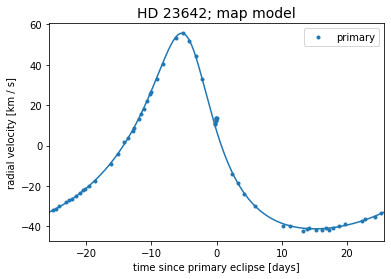

In [12]:
period = map_soln["period"]
t0 = map_soln["t0"]
# mean = map_soln["mean_rv"]

x_fold = (x_rv - t0 + 0.5 * period) % period - 0.5 * period
plt.plot(fold, y1_rv, ".", label="primary")
# plt.plot(fold, y2_rv - map_soln["mean_rv2"], ".", label="secondary")

x_phase = np.linspace(-0.5 * period, 0.5 * period, 500)
with model:
    y1_mod = xo.eval_in_model(
        model.model_rv1(x_phase + t0), map_soln
    )
plt.plot(x_phase, y1_mod, "C0")

plt.legend(fontsize=10)
plt.xlim(-0.5 * period, 0.5 * period)
plt.ylabel("radial velocity [km / s]")
plt.xlabel("time since primary eclipse [days]")
_ = plt.title("HD 23642; map model", fontsize=14)

In [13]:
with model:
    gp_pred = (
        xo.eval_in_model(model.gp_lc_pred, map_soln) + map_soln["mean_lc"]
    )
    lc = (
        xo.eval_in_model(model.model_lc(model.x), map_soln)
        - map_soln["mean_lc"]
    )
    

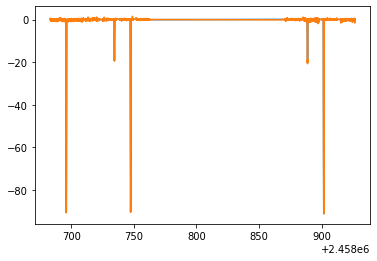

In [14]:
plt.plot(model.x, lc + gp_pred)
plt.plot(model.x, model.y)

In [20]:
np.random.seed(23642)
with model:
    trace = pmx.sample(
        tune=10,
        draws=10,
        start=map_soln,
        cores=4,
        chains=4,
        initial_accept=0.8,
        target_accept=0.95,
    )

/home/daniel/anaconda3/envs/starry/lib/python3.7/site-packages/pymc3_ext/sampling/schedule.py:34: UserWarning: there are not enough tuning steps to accomodate the tuning schedule; assigning automatically as 20%/70%/10%
  "there are not enough tuning steps to accomodate the tuning "
Only 10 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho_rv_gp, sigma_rv_gp, sigma_rv1, rho_gp, sigma_gp, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]


Sampling 4 chains for 10 tune and 10 draw iterations (40 + 40 draws total) took 17 seconds.
/home/daniel/anaconda3/envs/starry/lib/python3.7/site-packages/pymc3/sampling.py:629: UserWarning: The number of samples is too small to check convergence reliably.
  "The number of samples is too small to check convergence reliably."


In [11]:
with model:
    trace = pm.load_trace('exoplanet_trace')

In [14]:
with model:
    summary = pm.summary(
        trace, var_names=["q", "k", "R1", "R2", "ecs", "incl", "s"]
    )
summary



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
q,9.922,36.252,0.012,34.555,4.787,3.402,57.0,57.0,26.0,19.0,1.13
k,0.494,0.016,0.464,0.524,0.001,0.000,669.0,657.0,745.0,640.0,1.00
R1,11.989,22.746,2.065,53.090,5.926,4.276,15.0,15.0,26.0,19.0,1.13
R2,5.919,11.236,1.000,26.450,2.943,2.124,15.0,15.0,26.0,19.0,1.13
ecs[0],0.396,0.000,0.395,0.396,0.000,0.000,721.0,721.0,741.0,675.0,1.00
ecs[1],0.146,0.005,0.137,0.156,0.000,0.000,708.0,708.0,740.0,655.0,1.00
incl,1.507,0.000,1.506,1.507,0.000,0.000,754.0,754.0,820.0,691.0,1.00
s,0.953,0.033,0.892,1.014,0.001,0.001,831.0,831.0,844.0,936.0,1.00


In [15]:
with model:
    summary = pm.summary(
        trace, var_names=['sigma_lc'])
    
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_lc,0.133,0.0,0.132,0.133,0.0,0.0,2606.0,2606.0,2619.0,2694.0,1.0


In [18]:
np.median(trace.to_pandas()[['sigma_lc', 'sigma_gp', 'rho_gp']])

AttributeError: 'MultiTrace' object has no attribute 'to_pandas'

In [24]:
np.median(trace['rho_gp']), np.std(trace['rho_gp'])

(1.5544918177491702, 0.11337180151518275)

In [25]:
# pm.save_trace(trace, 'exoplanet_trace')

'exoplanet_trace'

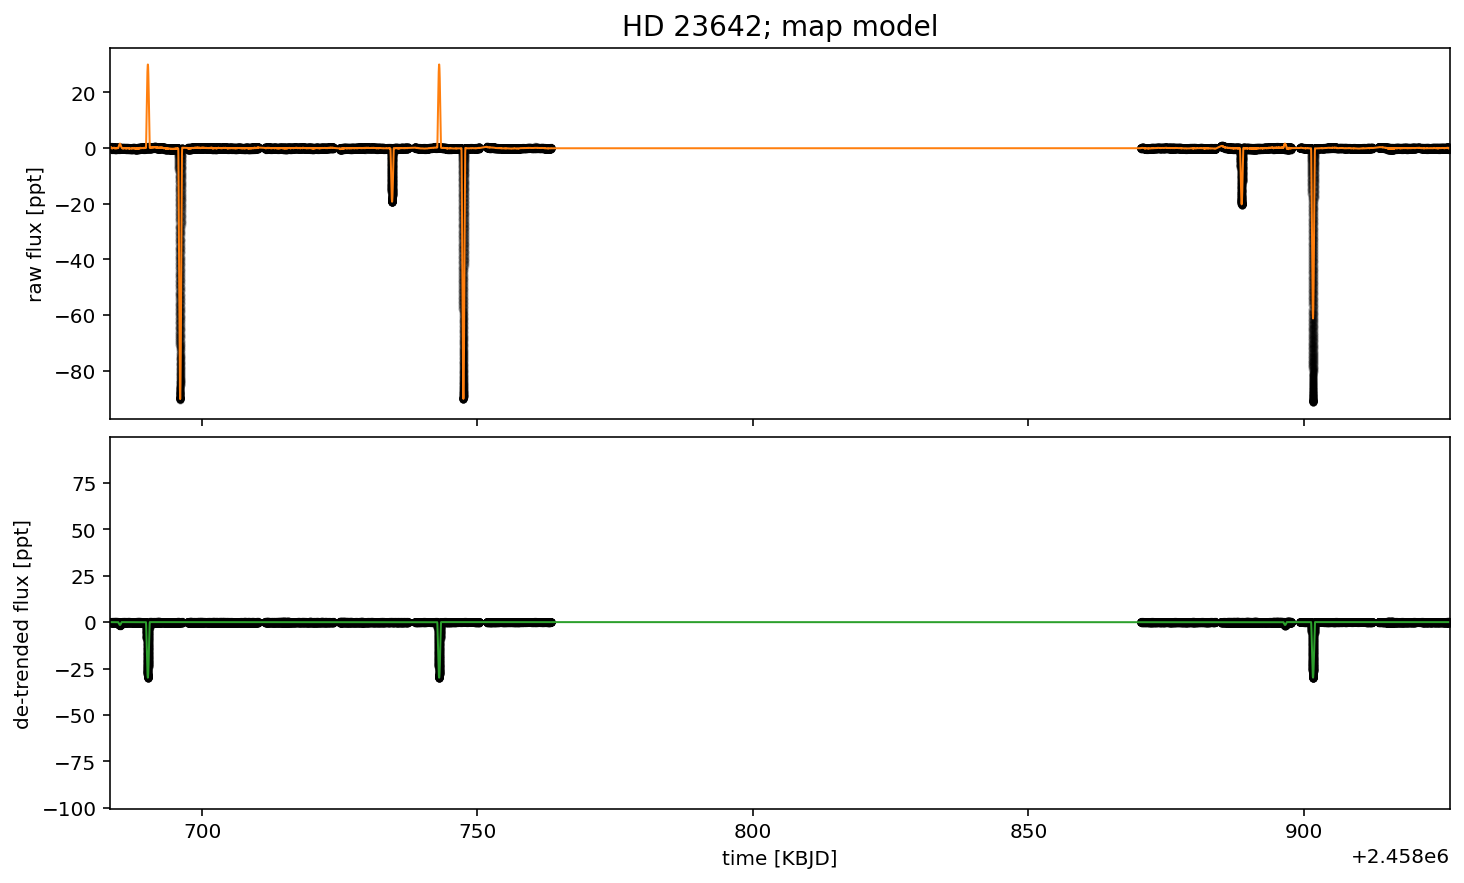

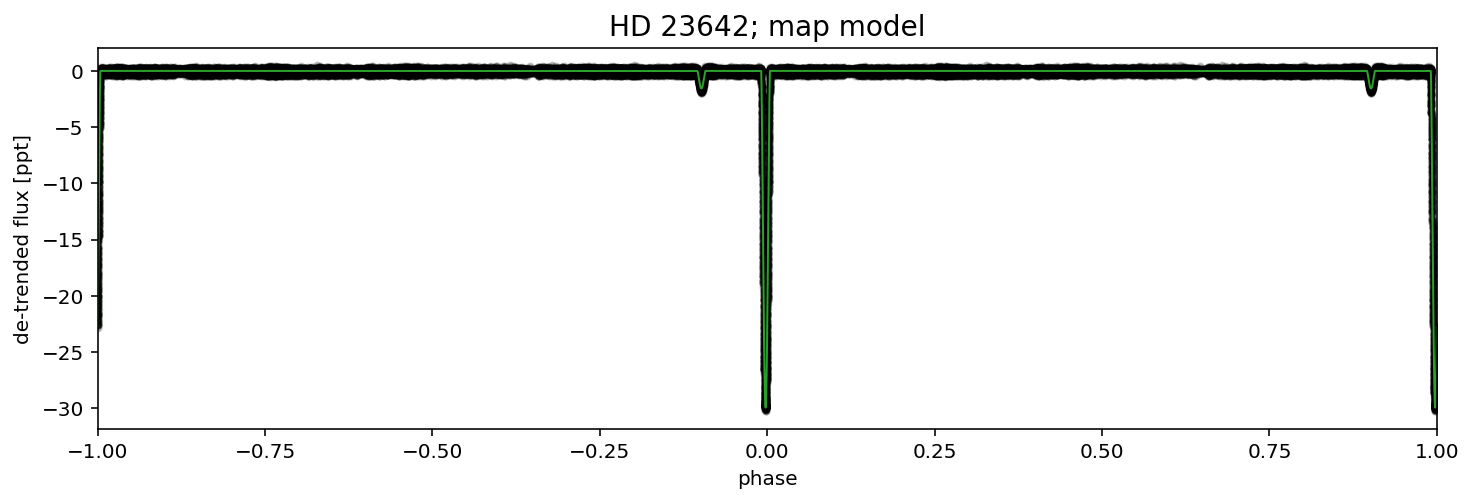

In [39]:
# with model:
#     gp_pred = xo.eval_in_model(model.gp_lc.predict(), map_soln) + map_soln["mean_lc"]
#     lc = xo.eval_in_model(model.model_lc(model.x), map_soln) - map_soln["mean_lc"]

# fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 7))

# ax1.plot(model.x, model.y, "k.", alpha=0.2)
# ax1.plot(model.x, gp_pred, color="C1", lw=1)

# ax2.plot(model.x, model.y - gp_pred, "k.", alpha=0.2)
# ax2.plot(model.x, lc, color="C2", lw=1)
# ax2.set_xlim(model.x.min(), model.x.max())

# ax1.set_ylabel("raw flux [ppt]")
# ax2.set_ylabel("de-trended flux [ppt]")
# ax2.set_xlabel("time [KBJD]")
# ax1.set_title("HD 23642; map model", fontsize=14)

# fig.subplots_adjust(hspace=0.05)

# fig, ax1 = plt.subplots(1, figsize=(12, 3.5))

# x_fold = (model.x - map_soln["t0"]) % map_soln["period"] / map_soln["period"]
# inds = np.argsort(x_fold)

# ax1.plot(x_fold[inds], model.y[inds] - gp_pred[inds], "k.", alpha=0.2)
# ax1.plot(x_fold[inds] - 1, model.y[inds] - gp_pred[inds], "k.", alpha=0.2)
# ax2.plot(x_fold[inds], model.y[inds] - gp_pred[inds], "k.", alpha=0.2, label="data!")
# ax2.plot(x_fold[inds] - 1, model.y[inds] - gp_pred, "k.", alpha=0.2)

# yval = model.y[inds] - gp_pred
# bins = np.linspace(0, 1, 75)
# num, _ = np.histogram(x_fold[inds], bins, weights=yval)
# denom, _ = np.histogram(x_fold[inds], bins)
# ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

# args = dict(lw=1)

# ax1.plot(x_fold[inds], lc[inds], "C2", **args)
# ax1.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

# ax1.set_xlim(-1, 1)
# ax1.set_ylabel("de-trended flux [ppt]")
# ax1.set_xlabel("phase")
# _ = ax1.set_title("HD 23642; map model", fontsize=14)